In [1]:
#!pip install librosa

  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201381 sha256=326fdaed7714fc41cd6dc39e540edc5b76079ac4fba17513517e2a03f8456b63
  Stored in directory: c:\users\smt078\appdata\local\pip\cache\wheels\32\2c\ce\86e49d4769aceba728421c24c0d726054bf4ca01175ff42bdd
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23146 sha256=e3caa5759b4c4d4379e5e9fbff987ec267caad52cabcf41886405ec64f0965a1
  Stored in directory: c:\users\smt078\appdata\local\pip\cache\wheels\de\14\0a\863e4ed680b3204444cf486733e609d7ff7abe8fceafab67dc
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320724 sha256=09213ed47e1eb924e0ac42a6c5d93926838cce37bec1cbafd818bd4e49ea6354
  Stored in directory: c:\users\smt078\appdata\local\pip\cache\wheels\cf\d4\04\49d8824a42bd9f9b11d502727965b9997f0d41d2b22ae4f645
Successfully built librosa audioread resampy


In [3]:
import librosa
import librosa.display     # 음성 출력
import numpy as np
import matplotlib.pyplot as plt
import IPython.display     # 음성 출력

In [7]:
data_dir = "./baby_sound/test/crying (30).wav"

# wav : 소리 데이터
# sr  : 샘플링 개수 (초기값 (default) 22050개)
wav, sr = librosa.load(data_dir, sr=22050)

print("sr 개수 :", sr)
print("wave shape(전체 샘플 수) :", wav.shape)   #전체샘플수
print("sounds length :",wav.shape[0]/float(sr))

sr 개수 : 22050
wave shape(전체 샘플 수) : (110250,)
sounds length : 5.0


In [8]:
IPython.display.Audio(data=wav, rate=sr)

### 시각화

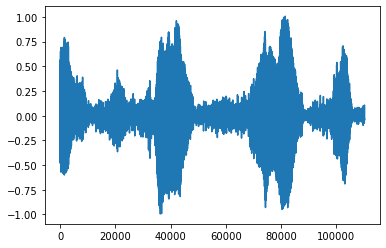

In [9]:
plt.plot(wav)      ## 이선의 개수들이 22050개인 것

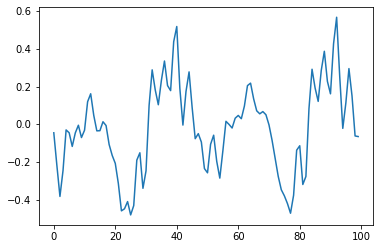

In [12]:
plt.plot(wav[:100])        ## 100개에 대한 음성만 뽑아 시각화 해본 것

### dB(데시벨)로 변환
- 위의 데이터들을 log 씌워서 데이벨로 바꿔보자

C:\Users\SMT078\anaconda3\envs\deep01\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1024
  n_fft, y.shape[-1]
C:\Users\SMT078\anaconda3\envs\deep01\lib\site-packages\librosa\core\spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


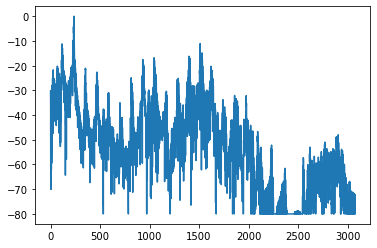

In [13]:
# 주파수 변환 (stft())
D = librosa.amplitude_to_db(librosa.stft(wav[:1024]), ref=np.max)

plt.plot(D.flatten())

### mel spectrum으로 변환

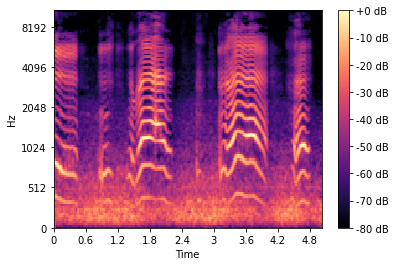

In [16]:
# 22050 -> =22KHz ..중심주파수 구함 11025Hz.... -> 이것을 128개로 구분하겠다는 것 
S = librosa.feature.melspectrogram(wav, sr=sr, n_mels=128)

# spectrum 데이터를 데시벨(db)로 변환
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+02.0f dB")         ##노란색일수록 큰소리

낮은 주파수로 이루어진 아기울음소리

### 아기 울음소리 인식

In [17]:
X_train = []         ##샘플데이터가 train
train_mfcc = []
y_train = []         ##울음?웃음?조용?이냐의 라벨 y

X_test = []
test_mfcc = []
y_test = []

In [20]:
# 소리 데이터를 같은 길이로 만들어주는 함수

# a : 소리데이터 (전체) (전체데이터의 길이)
# i : 샘플수
# hstack(a, b) : a와 b를 가로방향으로 붙이는 함수
pad1d = lambda a, i: a[0:i] if a.shape[0] > i else  np.hstack((a, np.zeros(i-a.shape[0])))

# def pad1d(a, i):
#     if a.shape[0] > i:
#         return a[0:i]
#     else:
#         return np.hstack((a, np.zeros(i-a.shape[0])))

# mfcc 데이터는 2차원
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros(a.shape[0], i-a.shape[1])))

In [18]:
# wav.shape[0]  #소리의 전체길이

110250

In [22]:
import os

train_dir = "./baby_sound/train/"

# 폴더로부터 파일을 하나씩 가져온다
for fileName in os.listdir(train_dir):
    try:
        # wav파일이 아니면 넘어가자(우리는 wav파일만 처리하려하기 때문)
        if '.wav' not in fileName:
            continue
            
        # 라벨을 저장
        y_train.append(fileName.split(' ')[0])
        
        # 소리 파일을 읽음
        wav, sr = librosa.load(train_dir + fileName)
        #소리 파일을 같은 길이로 잘라서, 특징 데이터로 저장
        X_train.append(pad1d(wav, 30000))
        
        # mfcc 계산
        mfcc = librosa.feature.mfcc(wav)   ##.mfcc()에 넣으면 간단한방법으로 mfcc 구할 수 있음
        # mfcc를 같은 길이로 잘라서 저장
        train_mfcc.append(pad2d(mfcc, 40)) ##40개씩만 잘라서 저장
        
    except:
        print("파일읽기 오류")

In [23]:
import os

test_dir = "./baby_sound/test/"

# 폴더로부터 파일을 하나씩 가져온다
for fileName in os.listdir(test_dir):
    try:
        # wav파일이 아니면 넘어가자(우리는 wav파일만 처리하려하기 때문)
        if '.wav' not in fileName:
            continue
            
        # 라벨을 저장
        y_test.append(fileName.split(' ')[0])
        
        # 소리 파일을 읽음
        wav, sr = librosa.load(test_dir + fileName)
        #소리 파일을 같은 길이로 잘라서, 특징 데이터로 저장
        X_test.append(pad1d(wav, 30000))
        
        # mfcc 계산
        mfcc = librosa.feature.mfcc(wav)   ##.mfcc()에 넣으면 간단한방법으로 mfcc 구할 수 있음
        # mfcc를 같은 길이로 잘라서 저장
        test_mfcc.append(pad2d(mfcc, 40)) ##40개씩만 잘라서 저장
        
    except:
        print("파일읽기 오류")